##### Disclaimer
Most of the code came from https://github.com/mstechly/quantum_tsp_tutorials/blob/master/tutorials/02_QAOA.ipynb (big thanks to Michał Stęchły, also for kindly responding to my emails), I adjusted some parts and played around with it. Using this I want to make a general programme that takes in a graph and an integer p, and then runs the rest itself. However, I have not been able to run it in Spyder or the like. Probably I should just adjust the virtual environment I am running in... - Joost

### Defining the Graph

In [1]:
first_graph = [(0, 1), (0, 2), (0, 3)]

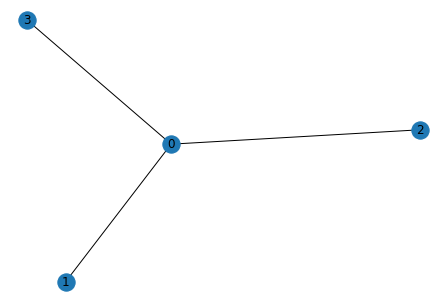

In [2]:
import networkx as nx

# making a graph object from the edge list first_graph
G = nx.Graph()
nodes = [3,2,1,0]

for node in nodes:
    G.add_node(node)
for edge in first_graph:
    G.add_edge(*edge)

#plotting the graph
pos=nx.spring_layout(G)
nx.draw(G,pos=pos)
labels = nx.draw_networkx_labels(G, pos=pos)

### Importing 

In [4]:
import numpy as np
from grove.pyqaoa.maxcut_qaoa import maxcut_qaoa
import pyquil.api as api
qvm_connection = api.QVMConnection()

In [5]:
print("I finally got it to work on a notebook!\n Still have to figure out how to get it to run on Spyder or some other interpreter (instead of a notebook) - Joost\n\n")

# Setting p (the number of angles, in the maxcut_qaoa method this is called 'steps')
p = 2 

# We initialize the maxcut_qaoa object with our graph
maxcut_solver = maxcut_qaoa(graph=first_graph, steps=p)
# The QAOA algorithm tries to find the optimal values of betas and gammas.
# This line is where all the optimization takes place.

betas, gammas = maxcut_solver.get_angles()
print("Values of betas:", betas)
print("Values of gammas:", gammas)

I finally got it to work on a notebook!
 Still have to figure out how to get it to run on Spyder or some other interpreter (instead of a notebook) - Joost


                     models will be ineffective
	Parameters: [1.82462465 2.10044416 0.11439377 1.40428835] 
	E => -2.1778030059273257
	Parameters: [1.82462465 2.10044416 0.11439377 1.40428835] 
	E => -1.9024646711139985
	Parameters: [1.82462465 2.10044416 0.11439377 1.40428835] 
	E => -2.049941773429535
	Parameters: [1.77104004 1.93999357 0.11620271 1.55338824] 
	E => -2.3168830642052853
	Parameters: [1.77104004 1.93999357 0.11620271 1.55338824] 
	E => -2.2887782348385466
	Parameters: [1.77104004 1.93999357 0.11620271 1.55338824] 
	E => -2.2500225395076088
	Parameters: [1.77104004 1.93999357 0.11620271 1.55338824] 
	E => -2.253076196600838
	Parameters: [1.77104004 1.93999357 0.11620271 1.55338824] 
	E => -2.2954508506271
	Parameters: [1.77104004 1.93999357 0.11620271 1.55338824] 
	E => -2.3140167938373266
	Parameters: [1.77104004 1

In [5]:
# We create an array of angles with correct format
angles = np.hstack((betas, gammas))
print(angles)

[1.12350186 1.86491149 4.08711688 4.3216614 ]


The above values are the $2p$ angles necessary for our QAOA circuit. Look at the [code](https://github.com/rigetti/grove/blob/master/grove/pyqaoa/maxcut_qaoa.py) to find out what's happening exactly.

### Building the circuit
using the angles we just determined, we can build the circuit and thereafter run it and analyze the results!

In [6]:
# We take a template for quil program from the maxcut_solver.
param_prog = maxcut_solver.get_parameterized_program()
# We initialize this program with the angles we have found
prog = param_prog(angles)
# Now we can print the program. 
# Some of the values you see here are the angles we calculated earlier.
print(prog)
print("Number of gates:", len(prog))

H 0
H 1
H 2
H 3
CNOT 0 1
RZ(4.087116878530143) 1
CNOT 0 1
X 0
PHASE(2.0435584392650714) 0
X 0
PHASE(2.0435584392650714) 0
CNOT 0 2
RZ(4.087116878530143) 2
CNOT 0 2
X 0
PHASE(2.0435584392650714) 0
X 0
PHASE(2.0435584392650714) 0
CNOT 0 3
RZ(4.087116878530143) 3
CNOT 0 3
X 0
PHASE(2.0435584392650714) 0
X 0
PHASE(2.0435584392650714) 0
H 0
RZ(-2.2470037160434018) 0
H 0
H 1
RZ(-2.2470037160434018) 1
H 1
H 2
RZ(-2.2470037160434018) 2
H 2
H 3
RZ(-2.2470037160434018) 3
H 3
CNOT 0 1
RZ(4.3216613997666204) 1
CNOT 0 1
X 0
PHASE(2.1608306998833102) 0
X 0
PHASE(2.1608306998833102) 0
CNOT 0 2
RZ(4.3216613997666204) 2
CNOT 0 2
X 0
PHASE(2.1608306998833102) 0
X 0
PHASE(2.1608306998833102) 0
CNOT 0 3
RZ(4.3216613997666204) 3
CNOT 0 3
X 0
PHASE(2.1608306998833102) 0
X 0
PHASE(2.1608306998833102) 0
H 0
RZ(-3.7298229838219203) 0
H 0
H 1
RZ(-3.7298229838219203) 1
H 1
H 2
RZ(-3.7298229838219203) 2
H 2
H 3
RZ(-3.7298229838219203) 3
H 3

Number of gates: 70


This is the circuit. Currently, not too appealing (visually) but I'll find a fix for that.

In [7]:
# These are just the ids of qubits we want to use.
# It's not very important if you don't use the real QPU.
qubits = [0, 1, 2, 3]
# Here we connect to the Forest API and run our program there.
# We do that 1000 times and after each one we measure the output.
measurements = qvm_connection.run_and_measure(prog, qubits, trials=1000)

### Results

In [8]:
# Since list of 1000 elements is hard to analyze, we use Counter
from collections import Counter
# This is just a hack - we can't use Counter on a list of lists but we can on a list of tuples.
measurements = [tuple(measurement) for measurement in measurements]
measurements_counter = Counter(measurements)
# This line gives us the results in the diminishing order
measurements_counter.most_common()

[((0, 1, 1, 1), 450),
 ((1, 0, 0, 0), 434),
 ((0, 0, 0, 1), 17),
 ((1, 1, 0, 1), 16),
 ((1, 1, 1, 0), 16),
 ((0, 1, 0, 0), 15),
 ((0, 0, 1, 0), 12),
 ((1, 0, 1, 1), 12),
 ((0, 1, 0, 1), 8),
 ((0, 1, 1, 0), 6),
 ((0, 0, 1, 1), 4),
 ((1, 0, 1, 0), 4),
 ((1, 1, 0, 0), 2),
 ((1, 1, 1, 1), 2),
 ((1, 0, 0, 1), 1),
 ((0, 0, 0, 0), 1)]

In [9]:
wf = qvm_connection.wavefunction(prog)
print(wf)

(-0.005167255+0.0291342097j)|0000> + (0.536015815+0.4012538237j)|0001> + (0.1180261445+0.016008441j)|0010> + (0.0439381111-0.0286118658j)|0011> + (0.1180261445+0.016008441j)|0100> + (0.0439381111-0.0286118658j)|0101> + (0.0439381111-0.0286118658j)|0110> + (0.1180261445+0.016008441j)|0111> + (0.1180261445+0.016008441j)|1000> + (0.0439381111-0.0286118658j)|1001> + (0.0439381111-0.0286118658j)|1010> + (0.1180261445+0.016008441j)|1011> + (0.0439381111-0.0286118658j)|1100> + (0.1180261445+0.016008441j)|1101> + (0.536015815+0.4012538237j)|1110> + (-0.005167255+0.0291342097j)|1111>


In [10]:
print("Probability amplitudes for all the possible states:")
for state_index in range(maxcut_solver.nstates):
    print(maxcut_solver.states[state_index], wf[state_index])

Probability amplitudes for all the possible states:
0000 (-0.005167254970244672+0.029134209674235342j)
0001 (0.5360158150263034+0.40125382367314666j)
0010 (0.11802614452458215+0.01600844103051062j)
0011 (0.04393811106260566-0.02861186580279597j)
0100 (0.11802614452458211+0.01600844103051064j)
0101 (0.043938111062605534-0.028611865802795997j)
0110 (0.04393811106260567-0.028611865802795927j)
0111 (0.11802614452458213+0.016008441030510613j)
1000 (0.11802614452458213+0.016008441030510613j)
1001 (0.04393811106260567-0.028611865802795927j)
1010 (0.043938111062605534-0.028611865802795997j)
1011 (0.11802614452458211+0.01600844103051064j)
1100 (0.04393811106260566-0.02861186580279597j)
1101 (0.11802614452458215+0.01600844103051062j)
1110 (0.5360158150263034+0.40125382367314666j)
1111 (-0.005167254970244672+0.029134209674235342j)


In [11]:
print("Probabilities of measuring given states:")
states_with_probs = []
for state_index in range(maxcut_solver.nstates):
    states_with_probs.append([maxcut_solver.states[state_index], np.real(np.conj(wf[state_index])*wf[state_index])])
    print(states_with_probs[-1][0], states_with_probs[-1][1])

Probabilities of measuring given states:
0000 0.0008755026972698265
0001 0.4483175849706329
0010 0.01418644097556489
0011 0.0027491964684670752
0100 0.01418644097556488
0101 0.0027491964684670657
0110 0.002749196468467074
0111 0.014186440975564884
1000 0.014186440975564884
1001 0.002749196468467074
1010 0.0027491964684670657
1011 0.01418644097556488
1100 0.0027491964684670752
1101 0.01418644097556489
1110 0.4483175849706329
1111 0.0008755026972698265


In [12]:
import matplotlib.pyplot as plt

def plot_state_histogram(states_with_probs):
    states = np.array(states_with_probs)[:,0]
    probs = np.array(states_with_probs)[:,1].astype(float)
    n = len(states_with_probs)
    plt.barh(range(n), probs, tick_label=states)
    plt.show()

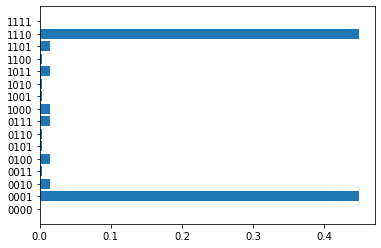

In [13]:
plot_state_histogram(states_with_probs)

In [14]:
opt_x, prob_x = sorted(states_with_probs,key=lambda x: x[1], reverse=True)[0]

print("Optimal bitstring is found to be "+ opt_x +", found with probability "+str(prob_x))
print("We used p = ",p)

Optimal bitstring is found to be 0001, found with probability 0.4483175849706329
We used p =  2


[0, 0, 0, 1]


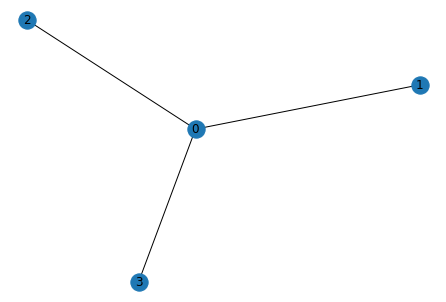

In [15]:
cut = [int(x) for x in list(opt_x)]
print(cut)

#plotting the graph
pos=nx.spring_layout(G)
nx.draw(G,pos=pos)
labels = nx.draw_networkx_labels(G, pos=pos)